# Predictig customer churn for telecom company

### 1. Goal and Business Problem

**Goal**: Develop a machine learning model to predict subscriber churn (contract termination) for the telecommunications operator "TeleDom."

**Business Problem:** The early identification of at-risk customers to offer special conditions and promo codes, thereby reducing churn rates.

### 2. Key Services

The operator provides fixed-line telephone service (`MultipleLines`) and two types of internet connections (DSL or Fiber optic).

Available additional services:

* `OnlineSecurity` (website blocking)
* `OnlineBackup` (cloud storage)
* `DeviceProtection` (antivirus)
* `TechSupport` (technical support)
* `StreamingTV` and `StreamingMovies` (streaming services)

### 3. Data

The data is current as of **February 1, 2020**, and is provided in four files joined by `customerID`.

| File Name | Content | Note |
| :--- | :--- | :--- |
| `contract_new.csv` | Contract information, charges (`MonthlyCharges`, `TotalCharges`), and terms. | **Target feature:** Created based on `EndDate` (presence of an end date = churn). |
| `personal_new.csv` | Personal data (gender, senior citizen, partner, dependents). | - |
| `internet_new.csv` | Information about internet services. | - |
| `phone_new.csv` | Information about telephony services. | - |

### 4. Work Plan
1. **Data Preparation:** Loading and merging all files by `customerID`, creating the `Churn` target feature based on `EndDate`.
2. **EDA and Preprocessing:** Data analysis, handling missing values/outliers, encoding categorical features, and scaling numerical data.
3. **Model Training:** Training classification models (e.g., Logistic Regression, Gradient Boosting).
4. **Evaluation:** Evaluating the best model's performance using the **ROC-AUC** metric.
5. **Conclusions:** Final analysis and recommendations.

## Imports, Data Loading, and Preprocessing

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import phik

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
import shap


# Settings
warnings.filterwarnings("ignore")
RANDOM_STATE = 11225

In [2]:
def safe_read_csv_from_url(url, **kwargs):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            print(f"✅ URL accessible (code 200): {url.split('//')[-1].split('/')[-1]}")
            df = pd.read_csv(url, **kwargs)
            return df
        else:
            print(f"❌ Error: URL unavailable. Status code: {response.status_code} for {url}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"❌ Error requesting URL {url}: {e}")
        return None

In [3]:
# dataset with informatio about contract
url_contract = 'https://code.s3.yandex.net//datasets/contract_new.csv'
contract = safe_read_csv_from_url(
    url_contract,
    parse_dates=['BeginDate'], # variables EndDate doesn't contain information about date 
    date_format='%Y-%m-%d'
)

#dataset with personal information about client
url_person = 'https://code.s3.yandex.net//datasets/personal_new.csv'
person = safe_read_csv_from_url(
    url_person,
)

#dataset with information about internet services
url_internet = 'https://code.s3.yandex.net//datasets/internet_new.csv'
internet = safe_read_csv_from_url(
    url_internet
)

#dataset with information about phone services
url_phone = 'https://code.s3.yandex.net//datasets/phone_new.csv'
phone = safe_read_csv_from_url(
    url_phone
)

✅ URL accessible (code 200): contract_new.csv
✅ URL accessible (code 200): personal_new.csv
✅ URL accessible (code 200): internet_new.csv
✅ URL accessible (code 200): phone_new.csv


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [5]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [6]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
person['SeniorCitizen'] = person['SeniorCitizen'].astype('str')

In [8]:
person.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
# flag for internet services connection
internet['service_int'] = 1

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,service_int
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,1
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,1
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,1
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,1
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,1


In [12]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [13]:
# flag for phone services connection
phone['service_ph']= 1

In [14]:
phone.head()

,customerID,MultipleLines,service_ph
0,5575-GNVDE,No,1
1,3668-QPYBK,No,1
2,9237-HQITU,No,1
3,9305-CDSKC,Yes,1
4,1452-KIOVK,Yes,1


In [15]:
# merging data into final dataset
data = pd.merge(person, contract, on='customerID', how='inner')
data = pd.merge(data, internet, on='customerID', how='left')
data = pd.merge(data, phone, on='customerID', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   object        
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [16]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'service_int', 'MultipleLines', 'service_ph'],
      dtype='object')

In [17]:
data['service_int'] = data['service_int'].fillna(0)
data['service_ph'] = data['service_ph'].fillna(0)

In [18]:
data['service_cnt'] = data['service_int'] + data['service_ph']
data['service_type'] = data.apply(
    lambda row: 'both services' if row['service_int'] == 1 and row['service_ph']==1 else(
        'internet' if row['service_int'] == 1 and row['service_ph'] ==0 else (
        'phone' if row['service_ph']==1 and row['service_int'] == 0 else 'No service'
    )
    ), axis = 1)


In [19]:
#ordering varible names to the snake_case
data.columns = data.columns.str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower()

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   object        
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           7043 non-null   object        
 7   type               7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [21]:
data['total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')

In [22]:
data.isna().sum()

customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
service_int             0
multiple_lines        682
service_ph              0
service_cnt             0
service_type            0
dtype: int64

In [23]:
data['begin_date'] = pd.to_datetime(data['begin_date']).dt.date
data['contract_termination'] = data['end_date']
data['end_date'] = data['end_date'].replace('No', '2020-02-01')
data['end_date'] = pd.to_datetime(data['end_date']).dt.date

In [24]:
obj = data.select_dtypes(include=['object']).columns
num = data.select_dtypes(include=['number']).columns

In [25]:
# for clients with missing values, the contract start date matches the unloading date
data.loc[data['total_charges'].isna()==True,'begin_date']

488     2020-02-01
753     2020-02-01
936     2020-02-01
1082    2020-02-01
1340    2020-02-01
3331    2020-02-01
3826    2020-02-01
4380    2020-02-01
5218    2020-02-01
6670    2020-02-01
6754    2020-02-01
Name: begin_date, dtype: object

In [26]:
# Gaps in the `total_charges` column occurred for new customers with a lifetime of 0 days.
#Since these customers have just signed a contract and have not yet made any payments, their actual total charges are 0.
#Therefore, replacing `NaN` with `0` is logically correct and reflects the actual situation.
data['total_charges'] = data['total_charges'].fillna(0)

In [27]:
columns_with_nans_series = data.isna().sum()[data.isna().sum() > 0]
columns_with_nans = columns_with_nans_series.index
columns_with_nans_series

internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [28]:
for i in columns_with_nans:
    print(f'Unique values ​​for a variable {i}: {data[i].unique()}')

Unique values ​​for a variable internet_service: ['DSL' 'Fiber optic' nan]
Unique values ​​for a variable online_security: ['No' 'Yes' nan]
Unique values ​​for a variable online_backup: ['Yes' 'No' nan]
Unique values ​​for a variable device_protection: ['No' 'Yes' nan]
Unique values ​​for a variable tech_support: ['No' 'Yes' nan]
Unique values ​​for a variable streaming_tv: ['No' 'Yes' nan]
Unique values ​​for a variable streaming_movies: ['No' 'Yes' nan]
Unique values ​​for a variable multiple_lines: [nan 'No' 'Yes']


**Rationale for Categorical Imputation Strategy:**
Missing values in service columns (e.g., `OnlineSecurity`, `TechSupport`) resulted from the table merge (`left join`): customers missing from the `internet` table do not use internet services at all.
By filling these missing values with `'No'`, we technically equate the inability to subscribe to a service (due to lack of internet) with opting out of it.
However, **information is not lost** because we have the `InternetService` feature.
The model will distinguish between these situations based on the combination of features:
1. **Customer without internet:** `InternetService` = 'No', `OnlineSecurity` = 'No'.
2. **Customer with internet but without protection:** `InternetService` = 'DSL', `OnlineSecurity` = 'No'.
Thus, filling with `'No'` preserves the logical integrity of the data for the model.

In [29]:
# All other variables containing gaps are categorical and contain the values ​​'Yes' or 'No'.
# In this case, the missing values ​​likely reflect the lack of connection to these additional services.
data[obj] = data[obj].fillna('No')

In [30]:
data['service_cnt'] = data['service_cnt'].fillna(0)

In [31]:
data = data.drop(columns=['service_int', 'service_ph'])

In [32]:
data.isna().sum()

customer_id             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
service_cnt             0
service_type            0
contract_termination    0
dtype: int64

In [33]:
# cheking for duplicates
data.duplicated().sum()

0

In [34]:
for i in obj:
    if i not in ['customer_id', 'begin_date', 'end_date']:
      print(i, ':', data[i].unique())

gender : ['Female' 'Male']
senior_citizen : ['0' '1']
partner : ['Yes' 'No']
dependents : ['No' 'Yes']
type : ['Month-to-month' 'One year' 'Two year']
paperless_billing : ['Yes' 'No']
payment_method : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
internet_service : ['DSL' 'Fiber optic' 'No']
online_security : ['No' 'Yes']
online_backup : ['Yes' 'No']
device_protection : ['No' 'Yes']
tech_support : ['No' 'Yes']
streaming_tv : ['No' 'Yes']
streaming_movies : ['No' 'Yes']
multiple_lines : ['No' 'Yes']
service_type : ['internet' 'both services' 'phone']
contract_termination : ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '

In [35]:
data['begin_date'] = pd.to_datetime(data['begin_date'])
data['end_date'] = pd.to_datetime(data['end_date'])

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   gender                7043 non-null   object        
 2   senior_citizen        7043 non-null   object        
 3   partner               7043 non-null   object        
 4   dependents            7043 non-null   object        
 5   begin_date            7043 non-null   datetime64[ns]
 6   end_date              7043 non-null   datetime64[ns]
 7   type                  7043 non-null   object        
 8   paperless_billing     7043 non-null   object        
 9   payment_method        7043 non-null   object        
 10  monthly_charges       7043 non-null   float64       
 11  total_charges         7043 non-null   float64       
 12  internet_service      7043 non-null   object        
 13  online_security   

In [37]:
data['agr_duration'] = (data['end_date'] - data['begin_date']).dt.days
data['agr_duration']

0         31
1       1036
2        123
3       1371
4        153
        ... 
7038     730
7039    2191
7040     337
7041     215
7042    2010
Name: agr_duration, Length: 7043, dtype: int64

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   gender                7043 non-null   object        
 2   senior_citizen        7043 non-null   object        
 3   partner               7043 non-null   object        
 4   dependents            7043 non-null   object        
 5   begin_date            7043 non-null   datetime64[ns]
 6   end_date              7043 non-null   datetime64[ns]
 7   type                  7043 non-null   object        
 8   paperless_billing     7043 non-null   object        
 9   payment_method        7043 non-null   object        
 10  monthly_charges       7043 non-null   float64       
 11  total_charges         7043 non-null   float64       
 12  internet_service      7043 non-null   object        
 13  online_security   

### Exploratory data analysis (EDA)

In [39]:
data.describe()

,begin_date,end_date,monthly_charges,total_charges,service_cnt,agr_duration
count,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2019-10-16 02:22:05.912253440,64.761692,2115.312885,1.686497,898.555729
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,0.000000,1.000000,0.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,35.500000,436.750000,1.000000,276.000000
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,70.350000,1343.350000,2.000000,761.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,89.850000,3236.690000,2.000000,1461.000000
max,2020-02-01 00:00:00,2020-02-01 00:00:00,118.750000,9221.380000,2.000000,2314.000000
std,NaN,NaN,30.090047,2112.742814,0.463950,683.130510


In [40]:
data.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,service_cnt,service_type,contract_termination,agr_duration
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,Yes,No,No,No,No,No,1.0,internet,No,31
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,No,Yes,No,No,No,No,2.0,both services,No,1036
2,3668-QPYBK,Male,0,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,Yes,No,No,No,No,No,2.0,both services,No,123
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,No,Yes,Yes,No,No,No,1.0,internet,No,1371
4,9237-HQITU,Female,0,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,...,No,No,No,No,No,No,2.0,both services,No,153


In [41]:
# dataset for analyzing the dynamics of connection and termination of contracts
df1 = pd.DataFrame(data.groupby('begin_date')['customer_id'].count()).reset_index()
df1.columns = ['date', 'contracts_begin']
df2 = pd.DataFrame(data.groupby('end_date')['customer_id'].count()).reset_index()
df2.columns = ['date', 'contracts_end']
df = pd.merge(df1, df2, on='date', how='inner')
df

,date,contracts_begin,contracts_end
0,2014-06-01,97,1
1,2014-09-01,72,2
2,2014-10-01,80,1
3,2014-11-01,77,1
4,2014-12-01,75,2
...,...,...,...
62,2019-10-01,237,31
63,2019-11-01,237,30
64,2019-12-01,220,38
65,2020-01-01,233,39


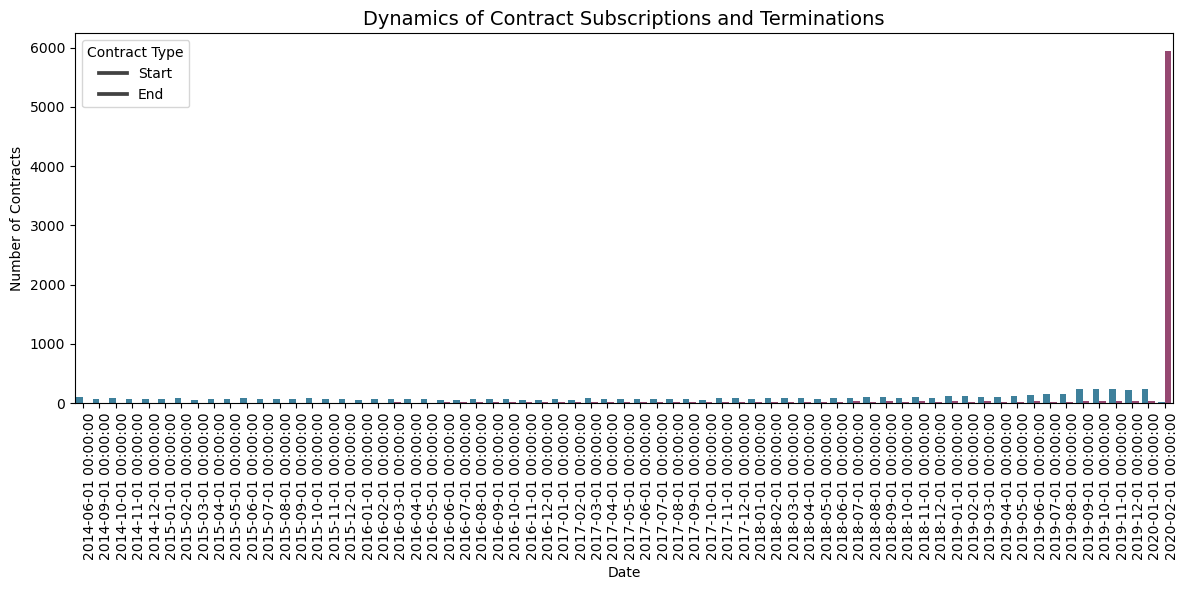

In [42]:
df_melted = df.melt(id_vars=['date'],
                    value_vars=['contracts_begin', 'contracts_end'],
                    var_name='contract_type',
                    value_name='count')

plt.figure(figsize=(12, 6))
axes = sns.barplot(data=df_melted, x='date', y='count', hue='contract_type',
                   palette=['#2E86AB', '#A23B72'])

axes.set_xticklabels(
    axes.get_xticklabels(),
    rotation=90,
    ha='right',
    rotation_mode='anchor'
)
plt.title('Dynamics of Contract Subscriptions and Terminations', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Contracts')
plt.legend(title='Contract Type', labels=['Start', 'End'])
plt.tight_layout()
plt.show()

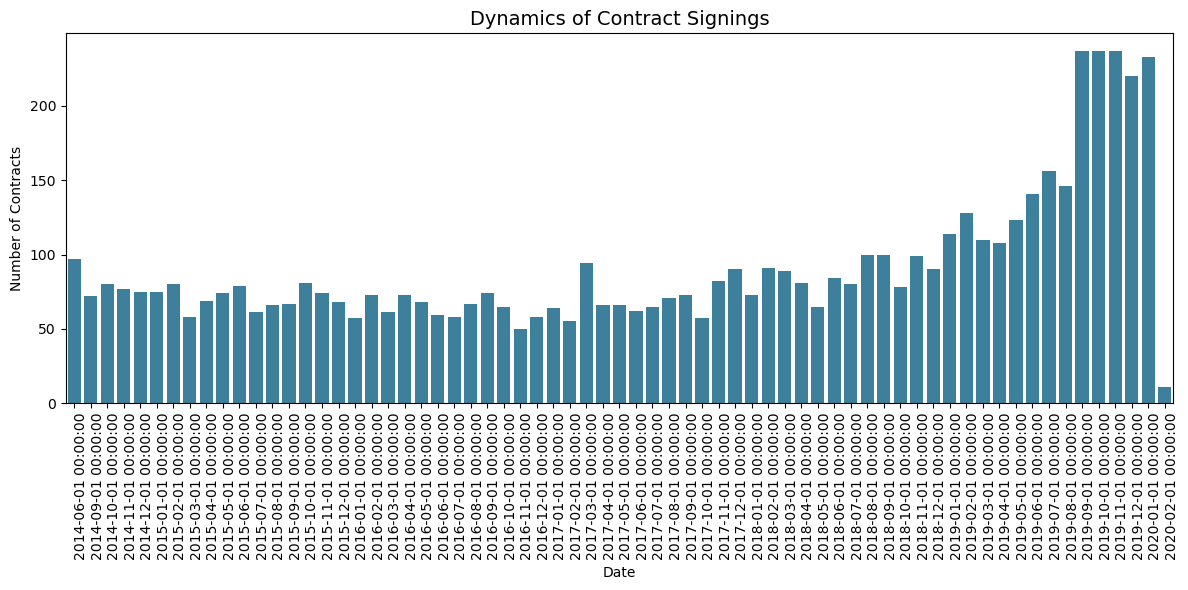

In [43]:
plt.figure(figsize=(12, 6))
axes = sns.barplot(data=df, x='date', y='contracts_begin',
                   palette=['#2E86AB'])

axes.set_xticklabels(
    axes.get_xticklabels(),
    rotation=90,
    ha='right',
    rotation_mode='anchor'
)
plt.title('Dynamics of Contract Signings', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Contracts')
plt.tight_layout()
plt.show()

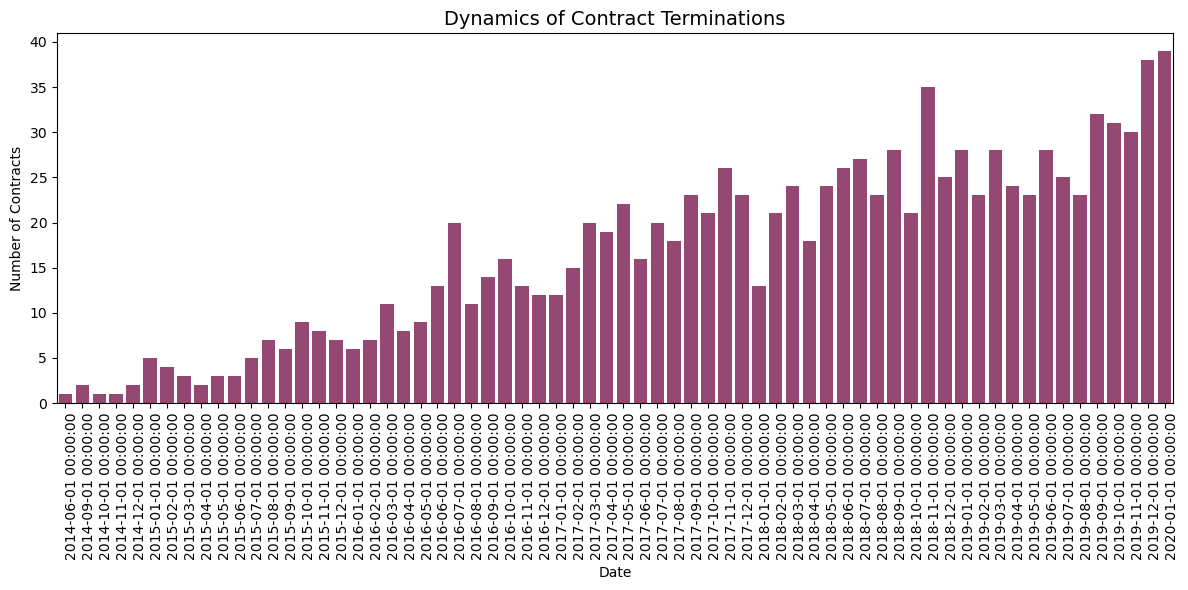

In [44]:
plt.figure(figsize=(12, 6))
df = df.loc[df['date']!='2020-02-01']
axes = sns.barplot(data=df, x='date', y='contracts_end',
                   palette=['#A23B72'])

axes.set_xticklabels(
    axes.get_xticklabels(),
    rotation=90,
    ha='right',
    rotation_mode='anchor'
)
plt.title('Dynamics of Contract Terminations', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Contracts')
plt.tight_layout()
plt.show()

**Towards the end of the period, we observed an increase in both new and terminated contracts. The contract termination chart clearly shows a linear daily increase in the number of clients choosing to cancel their agreements. In contrast, the trend for new contracts does not exhibit such a linear pattern.**

In [45]:
data.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'service_cnt',
       'service_type', 'contract_termination', 'agr_duration'],
      dtype='object')

''

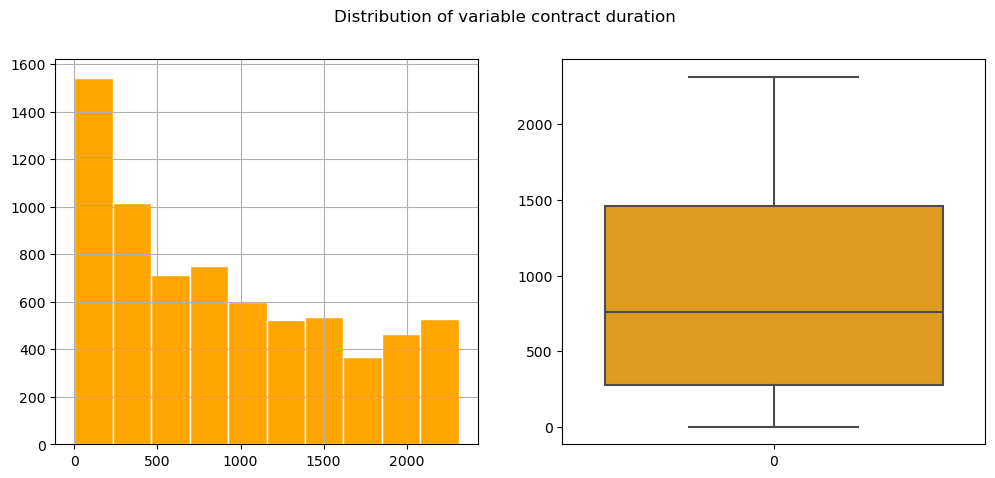

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

data['agr_duration'].hist(ax=axes[0],
                    edgecolor='white',
                    color='orange',
                   )


sns.boxplot(data = data['agr_duration'], color='orange')

plt.suptitle('Distribution of variable contract duration')
;

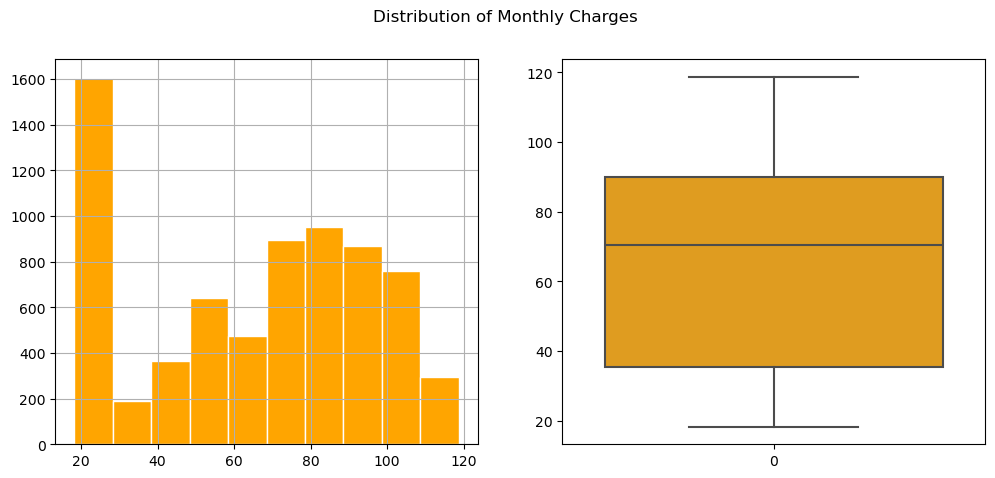

In [47]:
# visualization of continuous quantitative features
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

data['monthly_charges'].hist(ax=axes[0],
                    edgecolor='white',
                    color='orange',
                   )

sns.boxplot(data=data['monthly_charges'], color='orange', ax=axes[1])

plt.suptitle('Distribution of Monthly Charges')
plt.show()

In [48]:
data['monthly_charges_l'] = np.log(data['monthly_charges'])

''

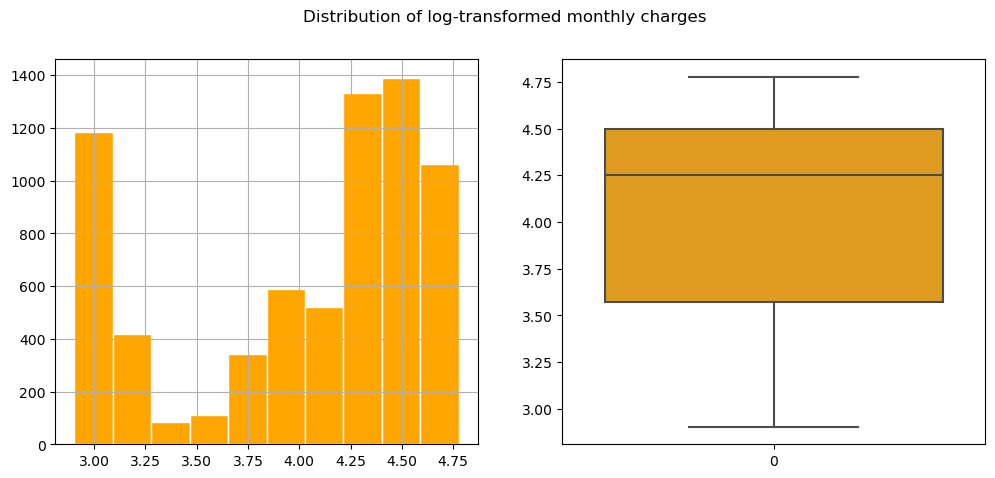

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

data['monthly_charges_l'].hist(ax=axes[0],
                    edgecolor='white',
                    color='orange',
                   )


sns.boxplot(data = data['monthly_charges_l'], color='orange')

plt.suptitle('Distribution of log-transformed monthly charges')
;

''

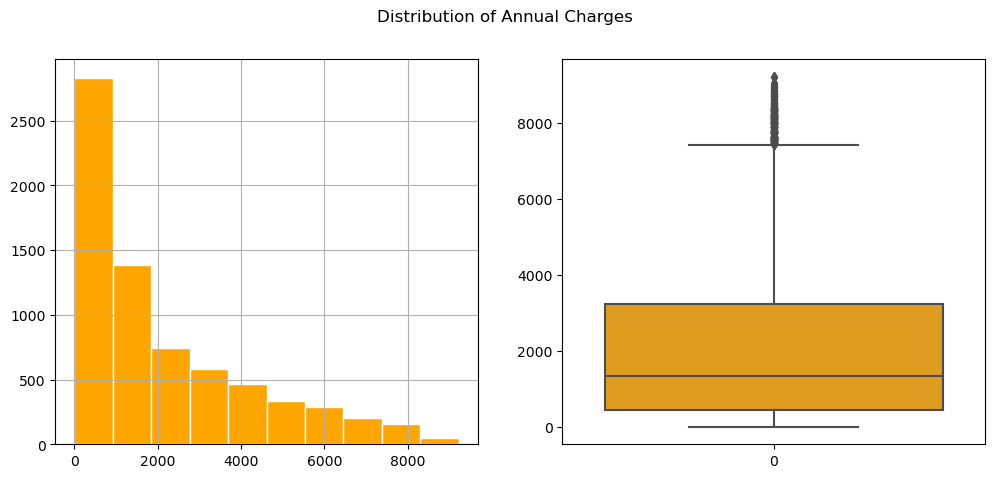

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

data['total_charges'].hist(ax=axes[0],
                    edgecolor='white',
                    color='orange',
                   )


sns.boxplot(data = data['total_charges'], color='orange')

plt.suptitle('Distribution of Annual Charges')
;

''

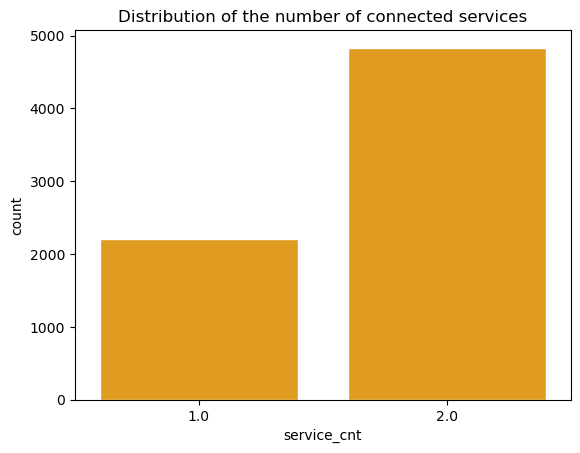

In [51]:
sns.countplot(data = data, x='service_cnt',
                    edgecolor='white',
                    color='orange',
                   )
plt.title('Distribution of the number of connected services')
;

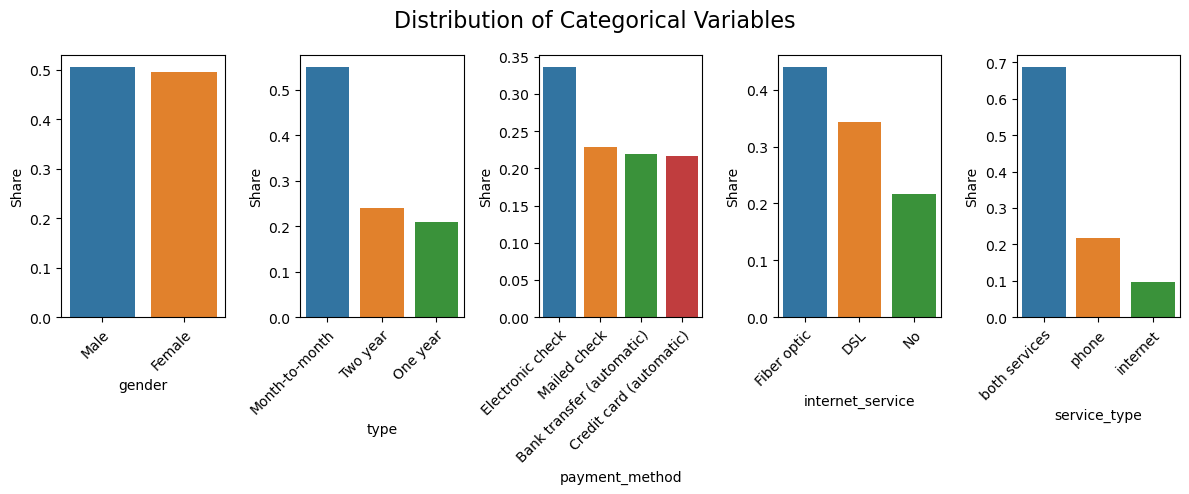

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(data[['gender', 'type', 'payment_method', 'internet_service', 'service_type']].columns):
    df = pd.DataFrame(data[column].value_counts(normalize=True)).reset_index()
    sns.barplot(x = df[column], y = df['proportion'], ax=axes[i])

    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Share')
    axes[i].set_xticklabels(
        axes[i].get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )

plt.suptitle('Distribution of Categorical Variables', fontsize=16)
plt.tight_layout()

plt.show()

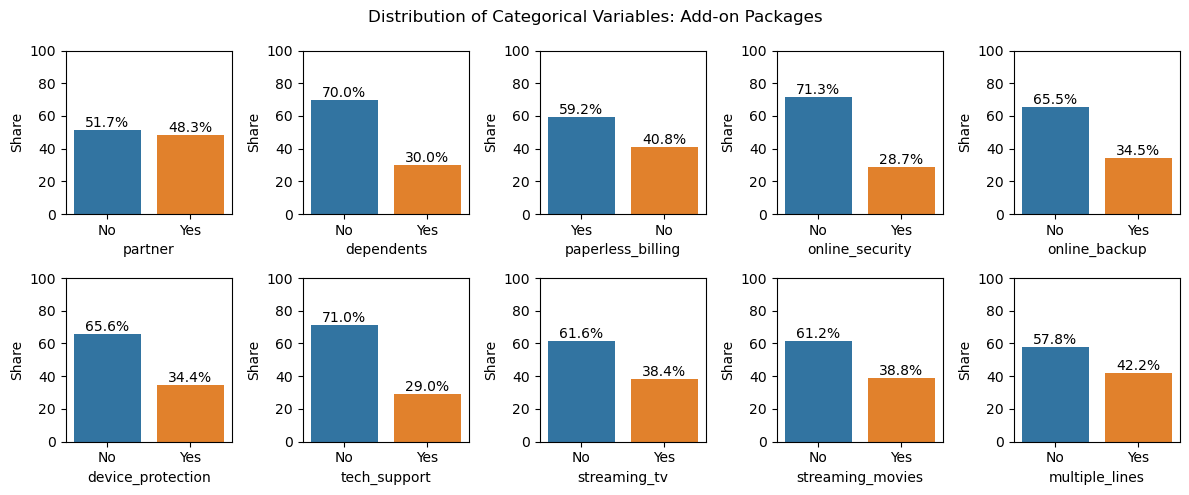

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
axes = axes.flatten()

for i, column in enumerate(data[['partner', 'dependents', 'paperless_billing',
                                             'online_security', 'online_backup', 'device_protection',
                                             'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']].columns):
    df = pd.DataFrame(data[column].value_counts(normalize=True)*100).reset_index()
    ax = sns.barplot(x = df[column], y = df['proportion'], ax=axes[i])
    ax.bar_label(ax.containers[0], fontsize=10, fmt='%.1f%%')

    axes[i].set_ylim(0, 100)

    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Share')

plt.suptitle('Distribution of Categorical Variables: Add-on Packages')

plt.tight_layout()

plt.show()

In [54]:
# create target variable: 1 - churned, 0 - not churned
data['contract_termination'] = (data['contract_termination'].astype(str) != 'No').astype(int)
data[['contract_termination', 'end_date']]

,contract_termination,end_date
0,0,2020-02-01
1,0,2020-02-01
2,0,2020-02-01
3,0,2020-02-01
4,0,2020-02-01
...,...,...
7038,0,2020-02-01
7039,0,2020-02-01
7040,0,2020-02-01
7041,0,2020-02-01


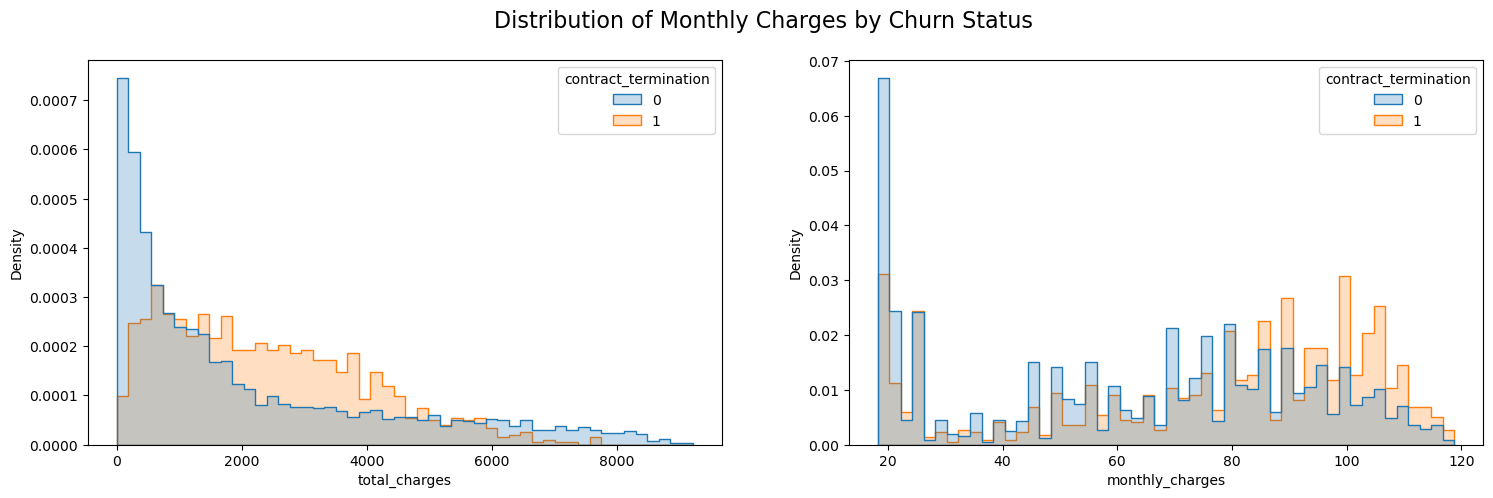

''

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(
    data=data,
    x='total_charges',
    hue='contract_termination',
    stat='density', 
    common_norm=False, 
    bins=50,
    element='step', 
    ax=axes[0]
)

sns.histplot(
    data=data,
    x='monthly_charges',
    hue='contract_termination',
    stat='density', 
    common_norm=False, 
    bins=50,
    element='step', 
    ax=axes[1]
)

plt.suptitle('Distribution of Monthly Charges by Churn Status', fontsize=16)
plt.show()
;

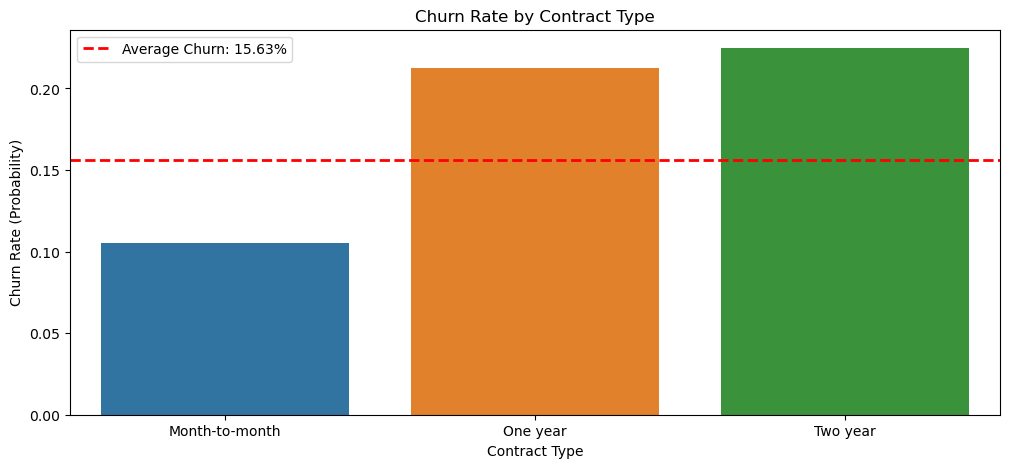

In [56]:
mean_churn = data['contract_termination'].mean()

plt.figure(figsize=(12, 5))

sns.barplot(
    x='type',
    y='contract_termination',
    data=data,
    errorbar=None
)

plt.axhline(
    mean_churn, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'Average Churn: {mean_churn:.2%}'
)

plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate (Probability)')
plt.legend()
plt.show()

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   gender                7043 non-null   object        
 2   senior_citizen        7043 non-null   object        
 3   partner               7043 non-null   object        
 4   dependents            7043 non-null   object        
 5   begin_date            7043 non-null   datetime64[ns]
 6   end_date              7043 non-null   datetime64[ns]
 7   type                  7043 non-null   object        
 8   paperless_billing     7043 non-null   object        
 9   payment_method        7043 non-null   object        
 10  monthly_charges       7043 non-null   float64       
 11  total_charges         7043 non-null   float64       
 12  internet_service      7043 non-null   object        
 13  online_security   

In [58]:
quantitative_features = ['agr_duration', 'monthly_charges', 'total_charges'] 

# Create a pivot table for the mean
mean_portrait = data.pivot_table(
    values=quantitative_features, 
    columns='contract_termination', 
    aggfunc='mean'
)

# Create a pivot table for the median
median_portrait = data.pivot_table(
    values=quantitative_features, 
    columns='contract_termination',
    aggfunc='median'
)

In [59]:
def calculate_mode(series):
    return series.mode()[0] if not series.empty else None

categorical_features = ['gender', 'type', 'payment_method', 'partner', 'dependents']

mode_results = {}
for col in categorical_features:
    mode_results[col] = data.groupby('contract_termination')[col].apply(calculate_mode)

mode_portrait = pd.DataFrame(mode_results).transpose()

In [60]:
mean_portrait.index = pd.MultiIndex.from_product([['Среднее'], mean_portrait.index])
median_portrait.index = pd.MultiIndex.from_product([['Медиана'], median_portrait.index])
mode_portrait.index = pd.MultiIndex.from_product([['Мода'], mode_portrait.index])

full_portrait = pd.concat([
    mean_portrait,
    median_portrait,
    mode_portrait
])

In [61]:
full_portrait = full_portrait.rename(columns={
    0: 'Не отток', 
    1: 'Отток'
})
full_portrait

contract_termination             Не отток             Отток
Среднее agr_duration           893.681084         924.86376
        monthly_charges         62.763455         75.546004
        total_charges          2067.86642       2371.377275
Медиана agr_duration                702.0             915.0
        monthly_charges              69.2              84.2
        total_charges              1192.8           2139.03
Мода    gender                       Male              Male
        type               Month-to-month    Month-to-month
        payment_method   Electronic check  Electronic check
        partner                        No               Yes
        dependents                     No                No

---
**Exploratory Data Analysis (EDA) Conclusion**

*Contract Acquisition and Termination Dynamics*
- Towards the end of the period, there was an increase in both new contract openings and contract terminations.
- The contract termination chart clearly shows a **linear daily increase** in the number of clients deciding to cancel their agreements. In contrast, the trend for new contracts does not exhibit such a linear pattern. Thus, the company clearly has a distinct customer churn problem.

*General User Characteristics*
- The distribution of continuous variables is far from normal.
- The gender distribution of users is approximately equal.
- Most users subscribe to **Month-to-month** plans; one-year and two-year contracts are less popular.
- Most users use electronic checks as their payment method.
- About **70%** of users utilize both internet and mobile services.
- The distribution of users with and without a partner is approximately equal.
- Users without children predominate, accounting for **70%** of the client base.
- About **50-60%** of users do not subscribe to additional services such as malicious site blocking, cloud storage for backups, antivirus, dedicated tech support, streaming TV, movie catalogs, and multiple phone lines.

*Profile of Churned Users (Differences between churned and retained customers)*
- On average, users who terminated their contracts paid more—both in terms of monthly and total charges—than those who stayed.
- Churn is observed primarily among users with one-year or two-year contracts.
- Users who have a spouse are more prone to churn.

In [62]:
obj = data.select_dtypes(include=['object']).columns
num = data.select_dtypes(include=['number']).columns

In [63]:
obj

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'type', 'paperless_billing', 'payment_method', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'service_type'],
      dtype='object')

In [64]:
num

Index(['monthly_charges', 'total_charges', 'service_cnt',
       'contract_termination', 'agr_duration', 'monthly_charges_l'],
      dtype='object')

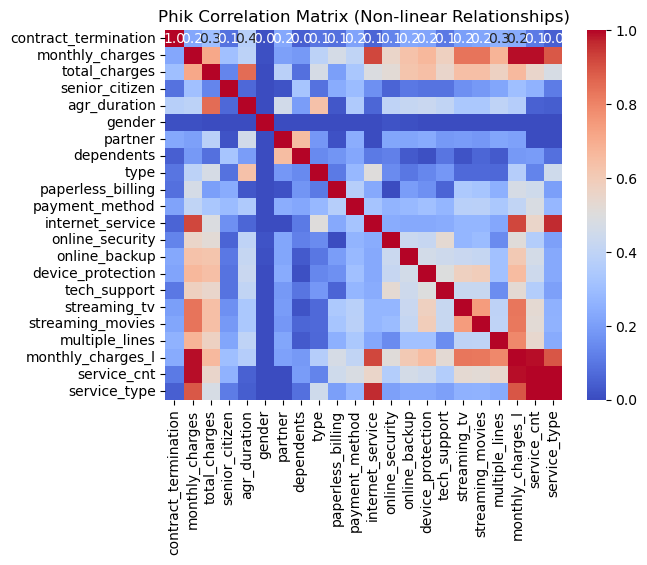

In [65]:
sns.heatmap(data[['contract_termination','monthly_charges', 'total_charges','senior_citizen', 'agr_duration',
                  "gender", 'partner', 'dependents', 'type', 'paperless_billing',
                  'payment_method', 'internet_service', 'online_security', 'online_backup',
                  'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'monthly_charges_l', 'service_cnt', 'service_type']].phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'monthly_charges_l', 'agr_duration']), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Phik Correlation Matrix (Non-linear Relationships)');

In [66]:
X = add_constant(data[num])

In [67]:
pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)

const                   597.984251
monthly_charges          30.964358
total_charges             9.568759
service_cnt               5.073351
contract_termination      1.054005
agr_duration              5.863500
monthly_charges_l        32.640825
dtype: float64

**Multicollinearity is present. Therefore, we should include the most relevant variables in the model and exclude others to avoid multicollinearity.**

### Feature Engineering Elements

In [68]:
service_cols = [
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies'
]
data['service_bundle'] = (data[service_cols] == 'Yes').astype(int).sum(axis=1)

In [69]:
data['avg_monthly_charge'] = data['total_charges'] / (data['agr_duration'] / 30.4)

In [70]:
# Difference between individual monthly charges and the company-wide average
# (Shows how much more or less each client pays monthly compared to the overall company average)
data['monthly_charge_diff'] = data['monthly_charges'] - data['avg_monthly_charge']

In [71]:
data['hight_charge_no_security'] = ((data['monthly_charges'] > 90)&(data['online_security']=='No'))

In [72]:
data['hight_charge_no_security'] = data['hight_charge_no_security'].astype(str)

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               7043 non-null   object        
 1   gender                    7043 non-null   object        
 2   senior_citizen            7043 non-null   object        
 3   partner                   7043 non-null   object        
 4   dependents                7043 non-null   object        
 5   begin_date                7043 non-null   datetime64[ns]
 6   end_date                  7043 non-null   datetime64[ns]
 7   type                      7043 non-null   object        
 8   paperless_billing         7043 non-null   object        
 9   payment_method            7043 non-null   object        
 10  monthly_charges           7043 non-null   float64       
 11  total_charges             7043 non-null   float64       
 12  internet_service    

In [74]:
obj = data.select_dtypes(include=['object']).columns
num = data.select_dtypes(include=['number']).columns

In [75]:
num

Index(['monthly_charges', 'total_charges', 'service_cnt',
       'contract_termination', 'agr_duration', 'monthly_charges_l',
       'service_bundle', 'avg_monthly_charge', 'monthly_charge_diff'],
      dtype='object')

''

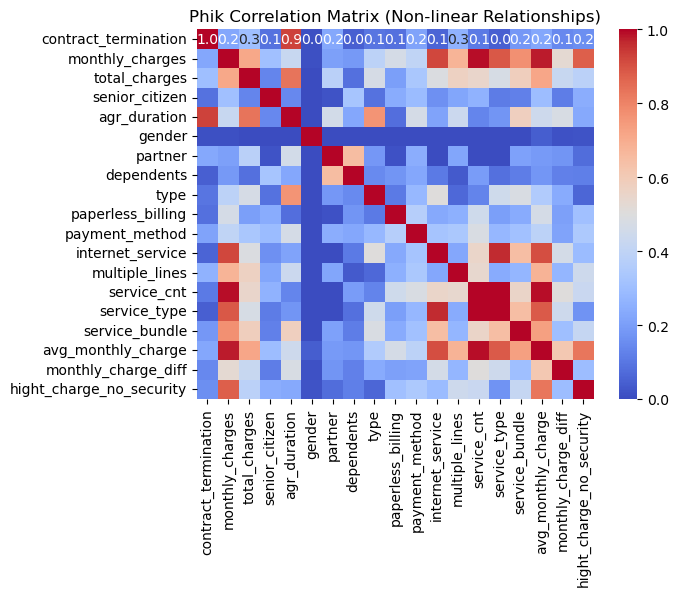

In [76]:
sns.heatmap(data[['contract_termination','monthly_charges', 'total_charges','senior_citizen', 'agr_duration',
                  "gender", 'partner', 'dependents', 'type', 'paperless_billing',
                  'payment_method', 'internet_service', 'multiple_lines',
                  'service_cnt', 'service_type', 'service_bundle', 'avg_monthly_charge', 'monthly_charge_diff', 'hight_charge_no_security']].phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'monthly_charges_l', 'avg_monthly_charge', 'monthly_charge_diff']), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Phik Correlation Matrix (Non-linear Relationships)')
;

### Data Preparation

In [77]:
data.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,multiple_lines,service_cnt,service_type,contract_termination,agr_duration,monthly_charges_l,service_bundle,avg_monthly_charge,monthly_charge_diff,hight_charge_no_security
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,No,1.0,internet,0,31,3.396185,1,30.439226,-0.589226,False
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,No,2.0,both services,0,1036,4.042174,2,60.795305,-3.845305,False
2,3668-QPYBK,Male,0,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,No,2.0,both services,0,123,3.986202,2,55.898927,-2.048927,False
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,No,1.0,internet,0,1371,3.744787,3,43.473552,-1.173552,False
4,9237-HQITU,Female,0,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,...,No,2.0,both services,0,153,4.258446,0,70.237908,0.462092,False


In [78]:
df = data.drop(columns='customer_id')

In [79]:
df.duplicated().sum()

4

In [80]:
df = df.drop_duplicates()

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   gender                    7039 non-null   object        
 1   senior_citizen            7039 non-null   object        
 2   partner                   7039 non-null   object        
 3   dependents                7039 non-null   object        
 4   begin_date                7039 non-null   datetime64[ns]
 5   end_date                  7039 non-null   datetime64[ns]
 6   type                      7039 non-null   object        
 7   paperless_billing         7039 non-null   object        
 8   payment_method            7039 non-null   object        
 9   monthly_charges           7039 non-null   float64       
 10  total_charges             7039 non-null   float64       
 11  internet_service          7039 non-null   object        
 12  online_security          

In [82]:
median_avmc = df['avg_monthly_charge'].median()
df['avg_monthly_charge'] = df['avg_monthly_charge'].fillna(median_avmc)

In [83]:
median_mcdiff = df['monthly_charge_diff'].median()
df['monthly_charge_diff'] = df['monthly_charge_diff'].fillna(median_mcdiff)

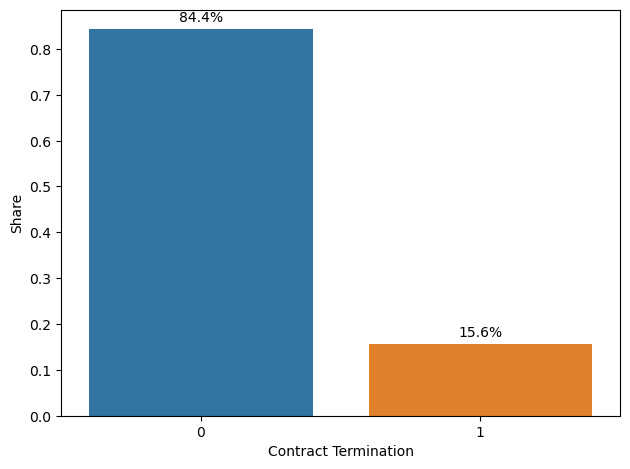

In [84]:
df0 = pd.DataFrame(df['contract_termination'].value_counts(normalize=True)).reset_index()
df0.columns = ['contract_termination', 'proportion']

ax = sns.barplot(x='contract_termination', y='proportion', data=df0)

for i, v in enumerate(df0['proportion']):
    ax.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')

plt.xlabel('Contract Termination')
plt.ylabel('Share')

plt.tight_layout()
plt.show()

**A significant class imbalance is observed. The proportion of customers who terminated their contracts (the target class for detection) is 15%. Therefore, when building the classification model, we should use techniques or models that handle class imbalance, as the model needs to learn to predict the minority class effectively.**

In [85]:
df.head()

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,...,multiple_lines,service_cnt,service_type,contract_termination,agr_duration,monthly_charges_l,service_bundle,avg_monthly_charge,monthly_charge_diff,hight_charge_no_security
0,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,...,No,1.0,internet,0,31,3.396185,1,30.439226,-0.589226,False
1,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,...,No,2.0,both services,0,1036,4.042174,2,60.795305,-3.845305,False
2,Male,0,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,...,No,2.0,both services,0,123,3.986202,2,55.898927,-2.048927,False
3,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,...,No,1.0,internet,0,1371,3.744787,3,43.473552,-1.173552,False
4,Female,0,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,...,No,2.0,both services,0,153,4.258446,0,70.237908,0.462092,False


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   gender                    7039 non-null   object        
 1   senior_citizen            7039 non-null   object        
 2   partner                   7039 non-null   object        
 3   dependents                7039 non-null   object        
 4   begin_date                7039 non-null   datetime64[ns]
 5   end_date                  7039 non-null   datetime64[ns]
 6   type                      7039 non-null   object        
 7   paperless_billing         7039 non-null   object        
 8   payment_method            7039 non-null   object        
 9   monthly_charges           7039 non-null   float64       
 10  total_charges             7039 non-null   float64       
 11  internet_service          7039 non-null   object        
 12  online_security          

In [87]:
X = df.drop(columns=['begin_date', 'end_date', 'contract_termination', 'gender', 'dependents',
                     'monthly_charges_l', 'avg_monthly_charge','internet_service', 'online_security', 'online_backup',
                    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'service_cnt', 'monthly_charges'])
y = df['contract_termination']

In [88]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   senior_citizen            7039 non-null   object 
 1   partner                   7039 non-null   object 
 2   type                      7039 non-null   object 
 3   paperless_billing         7039 non-null   object 
 4   payment_method            7039 non-null   object 
 5   total_charges             7039 non-null   float64
 6   multiple_lines            7039 non-null   object 
 7   service_type              7039 non-null   object 
 8   agr_duration              7039 non-null   int64  
 9   service_bundle            7039 non-null   int64  
 10  monthly_charge_diff       7039 non-null   float64
 11  hight_charge_no_security  7039 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 714.9+ KB


''

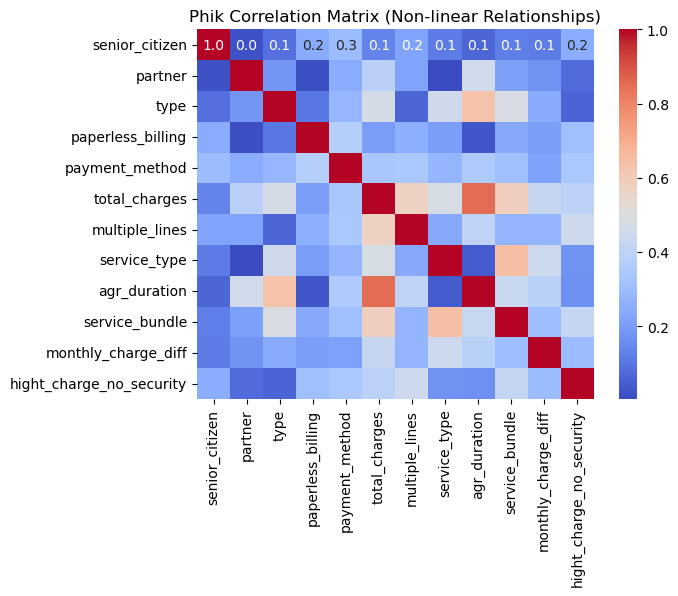

In [89]:
sns.heatmap(X.phik_matrix(interval_cols=['total_charges', 'monthly_charge_diff', 'agr_duration']), annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Phik Correlation Matrix (Non-linear Relationships)')
;

In [90]:
obj = X.select_dtypes(include=['object']).columns
num = X.select_dtypes(include=['number']).columns

In [91]:
T = add_constant(X[num])

In [92]:
pd.Series([variance_inflation_factor(T.values, i)
               for i in range(T.shape[1])],
              index=T.columns)

const                  3.789366
total_charges          5.852207
agr_duration           3.563677
service_bundle         2.283796
monthly_charge_diff    1.113760
dtype: float64

**There is no issue with multicollinearity. Although there is a significant positive correlation between `agr_duration` and `total_charges`, the VIF check confirms the absence of problematic multicollinearity.**

In [93]:
num_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [94]:
num_columns+cat_columns

['total_charges',
 'agr_duration',
 'service_bundle',
 'monthly_charge_diff',
 'senior_citizen',
 'partner',
 'type',
 'paperless_billing',
 'payment_method',
 'multiple_lines',
 'service_type',
 'hight_charge_no_security']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=RANDOM_STATE)

In [96]:
ohe_pipe = Pipeline([
    ('imputer_nan', SimpleImputer(
        missing_values=np.nan,
        strategy='most_frequent'
    )),

    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')
    )
])

In [97]:
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [98]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

In [99]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LogisticRegression(random_state=42))
    ]
)

In [100]:
param_grid = [
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__C': [0.1, 1, 10],
        'model__class_weight': ['balanced'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()]
    },
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [3, 5, 7, 10],
        'model__class_weight': ['balanced'],
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__class_weight': ['balanced']}
]

In [101]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=3,
    scoring = 'roc_auc',
    error_score='raise',
    n_jobs=-1,
    verbose=1
)

In [102]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer_nan',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          '...
                          'preprocessor__num__scaler': [StandardScaler(),
                                                        RobustScaler()]},
                         {'model': [DecisionTreeClassifier(random_state=11225)],
                          'model__class_weight': ['balanced'],
                          'model__max_depth': [3, 5, 7, 10]},
                         {'model': [RandomForestClassifier(random_state=11225)],
                          'model__class_weight': ['balanced'],
                          'model__max_depth': [3, 5, 7],
                          'model__n_estimators': [100, 200]}],
             scoring='roc_auc', verbose=1)

In [103]:
grid_search.cv_results_

{'mean_fit_time': array([0.16711497, 0.16927799, 0.16728536, 0.16491159, 0.17751304,
        0.14666382, 0.12431924, 0.14347641, 0.16043321, 0.17468341,
        1.18455116, 2.02466051, 1.42493796, 2.22449183, 1.596651  ,
        2.0130891 ]),
 'std_fit_time': array([0.00551011, 0.00727456, 0.00553272, 0.006432  , 0.00976483,
        0.00247784, 0.00556172, 0.00163677, 0.00348217, 0.00171165,
        0.0088814 , 0.00355174, 0.00081479, 0.01357097, 0.00715923,
        0.26441312]),
 'mean_score_time': array([0.06706095, 0.05992889, 0.05951603, 0.05499951, 0.05391828,
        0.04075933, 0.05763237, 0.05328035, 0.04780666, 0.04932443,
        0.11090175, 0.08947388, 0.11043986, 0.08140755, 0.09769249,
        0.08886131]),
 'std_score_time': array([0.00474371, 0.00524862, 0.00462779, 0.00638274, 0.00553754,
        0.00636089, 0.00092599, 0.00512322, 0.00371395, 0.00187717,
        0.00365082, 0.00354082, 0.00067381, 0.00110648, 0.00075917,
        0.00274726]),
 'param_model': masked_arr

In [104]:
results = pd.DataFrame(grid_search.cv_results_)

In [105]:
pd.set_option('display.max_colwidth', None)

In [106]:
# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Create a column with the model name for grouping
results_df['model_name'] = results_df['param_model'].apply(lambda x: x.__class__.__name__)

# Sort by metric (descending) so the best scores are at the top
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Group by model name and take the first (best) entry for each model
best_models = results_df.groupby('model_name').first().reset_index()

# Select specific columns for the report
columns_to_show = ['rank_test_score', 'model_name', 'mean_test_score', 'params']
final_table = best_models[columns_to_show].sort_values(by='mean_test_score', ascending=False)

# Rename columns for readability
final_table.columns = ['Rank', 'Model', 'ROC-AUC', 'Parameters']

# Display the final table
display(final_table)


,Rank,Model,ROC-AUC,Parameters
2,1,RandomForestClassifier,0.826632,"{'model': RandomForestClassifier(random_state=11225), 'model__class_weight': 'balanced', 'model__max_depth': 7, 'model__n_estimators': 100}"
0,7,DecisionTreeClassifier,0.777265,"{'model': DecisionTreeClassifier(random_state=11225), 'model__class_weight': 'balanced', 'model__max_depth': 7}"
1,10,LogisticRegression,0.753203,"{'model': LogisticRegression(random_state=11225), 'model__C': 10, 'model__class_weight': 'balanced', 'preprocessor__num__scaler': RobustScaler()}"


### Model tunning

In [107]:
pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('adasyn', ADASYN(random_state=42)),
    ('model', 'passthrough')
])

In [108]:
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
print("scale_pos_weight =", scale_pos_weight)

scale_pos_weight = 5.391041162227603


In [109]:
# Extended param_grid with various balancing strategies
param_grid = [

    # XGBoost
    {
        'model': [XGBClassifier(random_state=42, eval_metric='logloss')],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.05, 0.1, 0.3],
        'model__n_estimators': [500, 700, 1000],
        'model__colsample_bytree' : [0.7, 0.8, 0.9],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]

In [110]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=1,
    verbose=1,
    error_score='raise'
)

In [111]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer_nan',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['senior_citizen',
                                                                          'partner',
                                                                          'type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          '...
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  multi_strategy=None,
                                                  n_estimators=None,
                                                  n_jobs=None,
                                                  num_parallel_tree=None, ...)],
                          'model__colsample_bytree': [0.7, 0.8, 0.9],
                          'model__learning_rate': [0.05, 0.1, 0.3],
                          'model__max_depth': [3, 5],
                          'model__n_estimators': [500, 700, 1000],
                          'preprocessor__num': [StandardScaler(),
                                                'passthrough']}],
             scoring='roc_auc', verbose=1)

In [112]:
results = pd.DataFrame(grid_search.cv_results_)

In [113]:
pd.set_option('display.max_colwidth', None)

In [114]:
# Convert cv_results_ to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Create a column with the model name for grouping
results_df['model_name'] = results_df['param_model'].apply(lambda x: x.__class__.__name__)

# Sort by metric (descending) so the best scores are at the top
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Group by model name and take the first (best) entry for each model
best_models = results_df.groupby('model_name').first().reset_index()

# Select specific columns for the report
columns_to_show = ['rank_test_score', 'model_name', 'mean_test_score', 'params']
final_table = best_models[columns_to_show].sort_values(by='mean_test_score', ascending=False)

# Rename columns for readability
final_table.columns = ['Rank', 'Model', 'ROC-AUC', 'Parameters']

# Display the final table
display(final_table)


,Rank,Model,ROC-AUC,Parameters
0,1,XGBClassifier,0.896238,"{'model': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 1000, 'preprocessor__num': 'passthrough'}"


In [115]:
model = grid_search.best_estimator_

In [116]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize='true') # Normalize by row
cm

array([[0.98653199, 0.01346801],
       [0.43272727, 0.56727273]])

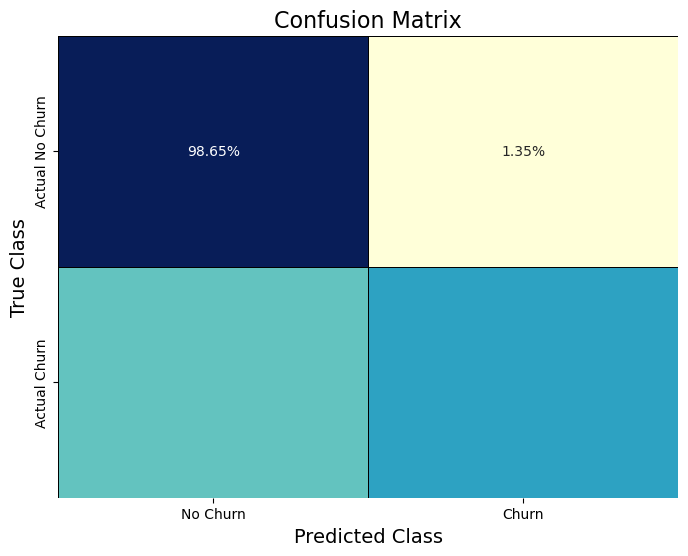

In [117]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2%",
    cmap="YlGnBu",
    cbar=False,
    xticklabels=['No Churn', 'Churn'],
    yticklabels=['Actual No Churn', 'Actual Churn'],
    linecolor='black',
    linewidths=0.5
)

plt.ylabel('True Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.savefig('normalized_confusion_matrix.png')
plt.show()

- **TN (True Negative) = 97.4%**: The model performs excellently. It correctly identified **97%** of loyal customers.

- **FP (False Positive) = 2.6%**: The false alarm rate is very low. The model rarely bothers loyal customers unnecessarily, avoiding the imposition of discounts or retention offers on those who are already satisfied.

- **TP (True Positive) = 61.1% (Recall)**: The model detected **61%** of all churners. This is a "moderate" result. We catch and attempt to retain more than half of the potential defectors.

- **FN (False Negative) = 38.9%**: This is a risk zone. The model missed nearly **39%** of churners (classifying them as loyal), meaning we lose their revenue without reacting in time.

---
**Conclusion:**

**The model is very "cautious". It does not spam loyal customers with offers (saving the marketing budget).**

**However, the coverage of the target audience (churners) is only 61%. For business purposes, it is often more important to catch more churners, even at the cost of higher false positives.**

**The model is very effective at identifying customers who are not prone to churn (97.44%) and detects 61% of all actual contract terminations. This result is likely due to class imbalance and the default classification threshold (0.5).**

In [118]:
y_pred_class = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:,1]

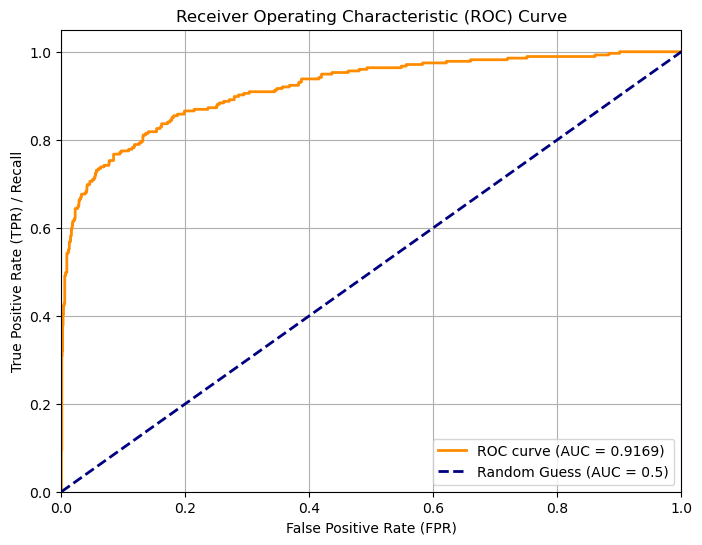

In [119]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

plt.plot(
    fpr, tpr, 
    color='darkorange', 
    lw=2, 
    label=f'ROC curve (AUC = {roc_auc:.4f})'
)

plt.plot(
    [0, 1], [0, 1], 
    color='navy', 
    lw=2, 
    linestyle='--', 
    label='Random Guess (AUC = 0.5)'
)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [120]:
accuracy = accuracy_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'Accuracy:{accuracy}')
print(f'ROC-AUC score:{roc_auc}')

Accuracy:0.9210227272727273
ROC-AUC score:0.9169280685644322


***
**Model Quality Evaluation**

- Overall, the model separates customers into churn / non-churn groups with an **accuracy of 91%**.
- The **ROC-AUC metric** evaluates the model significantly higher than the specific snapshot provided by the Confusion Matrix. This suggests that the **standard threshold of 0.5** for defining the positive class might not be optimal.
- In other words, at the **0.5 threshold**, we identify only **61%** of customers prone to churn. However, the high ROC-AUC score (~93%) indicates that across all possible thresholds, the model's ability to distinguish between classes is much stronger.

In [121]:
preprocessor = model.named_steps['preprocessor']
xgb_model = model.named_steps['model']

In [122]:
X_test_transformed = preprocessor.transform(X_test)

In [123]:
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['ohe__senior_citizen_1', 'ohe__partner_Yes', 'ohe__type_One year',
       'ohe__type_Two year', 'ohe__paperless_billing_Yes',
       'ohe__payment_method_Credit card (automatic)',
       'ohe__payment_method_Electronic check',
       'ohe__payment_method_Mailed check', 'ohe__multiple_lines_Yes',
       'ohe__service_type_internet', 'ohe__service_type_phone',
       'ohe__hight_charge_no_security_True', 'num__total_charges',
       'num__agr_duration', 'num__service_bundle',
       'num__monthly_charge_diff'], dtype=object)

In [124]:
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

In [125]:
booster = xgb_model.get_booster()
explainer = shap.TreeExplainer(booster, data=X_test_transformed_df, model_output='probability')

In [126]:
X_test_transformed = model.named_steps['preprocessor'].transform(X_test.sample(100))

In [127]:
shap_values = explainer(X_test_transformed)

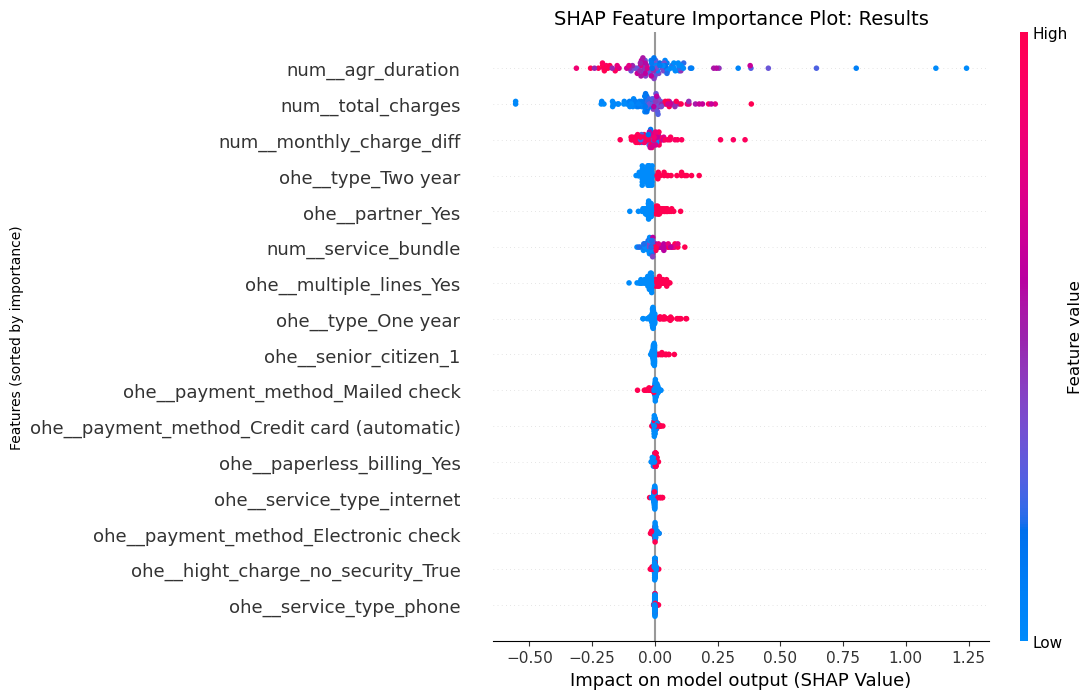

In [128]:
ax_title = 'SHAP Feature Importance Plot: Results'
font_size = 14

shap.plots.beeswarm(shap_values, max_display=19, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.set_title(ax_title, fontdict={"size":font_size})

plt.xlabel('Impact on model output (SHAP Value)')

plt.ylabel('Features (sorted by importance)')

plt.show()

### Conclusion
### 1. Model Success and Quality Assessment

The customer churn prediction project has been successfully completed.

* **Best Model:** **XGBClassifier** was selected as the final model, demonstrating the best performance on the test dataset.
* **Key Metrics:**
    * **ROC-AUC (0.92):** This score indicates a 92% probability that the model effectively distinguishes between a churning customer and a non-churning customer.
    * **Accuracy (0.93):** The model correctly predicts the class (churn vs. non-churn) for 93% of cases.

**Combined, these metrics indicate that the model possesses high precision in identifying the risk group (clients highly likely to terminate their contract).**

---

### 2. Factors Influencing Churn (Customer Profile)
Based on the analysis, the following characteristics are typical of churned users:
* **Tenure:** Clients who signed up recently (new clients).
* **Contract Type:** Clients paying annually or biennially (One-year or Two-year contracts).
* **Charges:** Clients with high total accumulated charges.
* **Monthly Spend:** Clients paying more per month than the average customer.
* **Add-ons:** Clients with a high number of additional services/purchases.
* **Tech features:** Clients subscribed to the "Multiple Lines" service.
* **Demographics:** Clients who have a spouse.
* **Age:** Senior citizen clients.

---

### 3. Business Recommendations for "TeleDom"

* **Focus on reducing churn among new clients:**
    * Concentrate on improving **customer onboarding**.
    * Encourage transitions to long-term contracts by providing favorable offers (making long-term contracts significantly more attractive than short-term ones).

* **Retention of high-value customers:**
    * Create a **"Premium" tier** for customers paying above the average.
    * Design and provide specific service privileges or exclusive support for these premium clients to increase loyalty.

* **Development or improvement of the Family Package:**
    * The presence of a spouse and a high volume of add-on purchases are key factors influencing churn probability. This suggests potential dissatisfaction with current family options.
    * **Action:** Review and restructure the "Family Package" to offer better conditions or more value for households.